In [55]:
import torch
from pytorch_metric_learning import losses
import data_handler
from siamese_network import SiameseNetwork, train
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from custom_losses import ContrastiveLoss
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.zeros(1).cuda()
#print(f"torch version: {torch.__version__}")

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"torch cuda available: {torch.cuda.is_available()}")

torch cuda available: True


# Data Management

In [3]:
df_data, _ = data_handler.load(path="dataset/", filename_train="train.csv", sep_char='#')

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   argument   20635 non-null  object 
 1   key_point  20635 non-null  object 
 2   topic      20635 non-null  object 
 3   label      20635 non-null  float64
dtypes: float64(1), object(3)
memory usage: 645.0+ KB


In [32]:
df_data['label'].value_counts()

0.0    16375
1.0     4260
Name: label, dtype: int64

<AxesSubplot: title={'center': 'Labels Proportions in Dataset'}>

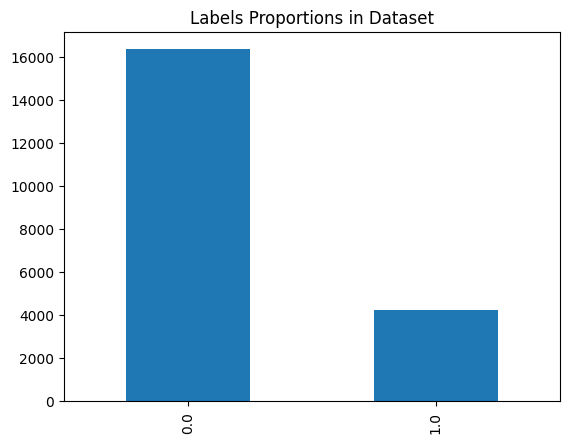

In [44]:
df_data['label'].value_counts().plot.bar(title='Labels Proportions in Dataset')

In [38]:
# Perform a stratified split dividing it into 80% training set and 20% validation set
df_train, df_val = data_handler.split_train_data(df_data, perc_split=0.8)

zero_train:  13100
one_train:  3408
zero_val:  3275
one_val:  852


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16508 entries, 0 to 16471
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   argument   16508 non-null  object 
 1   key_point  16508 non-null  object 
 2   topic      16508 non-null  object 
 3   label      16508 non-null  float64
dtypes: float64(1), object(3)
memory usage: 644.8+ KB


In [40]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4127 entries, 16520 to 20634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   argument   4127 non-null   object 
 1   key_point  4127 non-null   object 
 2   topic      4127 non-null   object 
 3   label      4127 non-null   float64
dtypes: float64(1), object(3)
memory usage: 161.2+ KB


<AxesSubplot: title={'center': 'Labels Proportions in Training set'}>

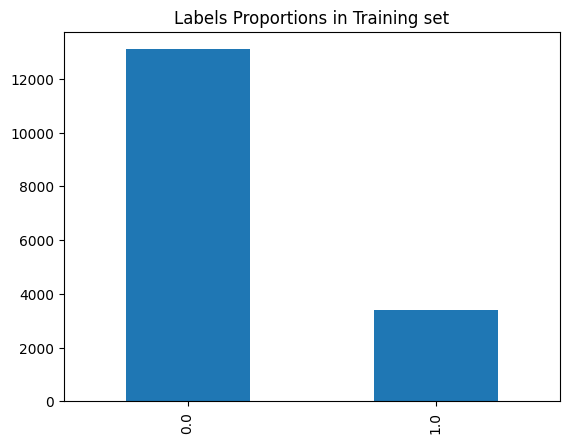

In [43]:
df_train['label'].value_counts().plot.bar(title='Labels Proportions in Training set')

<AxesSubplot: >

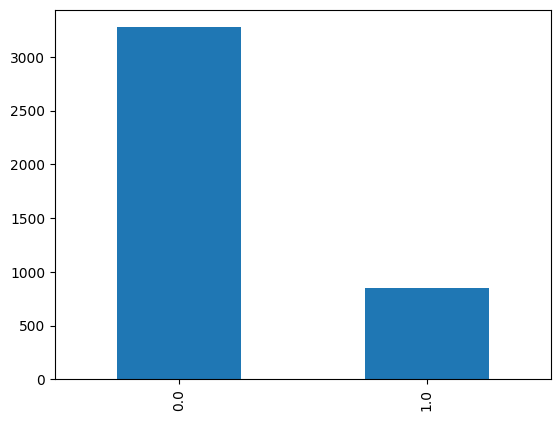

In [42]:
df_val['label'].value_counts().plot.bar(title='Labels Proportions in Validation set')

In [46]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train)
df_val = data_handler.concatenate_topics(df_val)

In [49]:
df_train.info()
print('--------')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16508 entries, 0 to 16507
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   args        16508 non-null  object 
 1   key_points  16508 non-null  object 
 2   labels      16508 non-null  float64
dtypes: float64(1), object(2)
memory usage: 387.0+ KB
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4127 entries, 0 to 4126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   args        4127 non-null   object 
 1   key_points  4127 non-null   object 
 2   labels      4127 non-null   float64
dtypes: float64(1), object(2)
memory usage: 96.9+ KB


In [52]:
df_train = df_train[13200:13500]
df_train = df_train.reset_index()
df_train[:100]

In [57]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['args'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['args'].str.split().apply(len)
n_words['words_per_kp_train'] = df_train['key_points'].str.split().apply(len)
n_words['words_per_kp_val'] = df_val['key_points'].str.split().apply(len)

Considerazioni varie...

<AxesSubplot: >

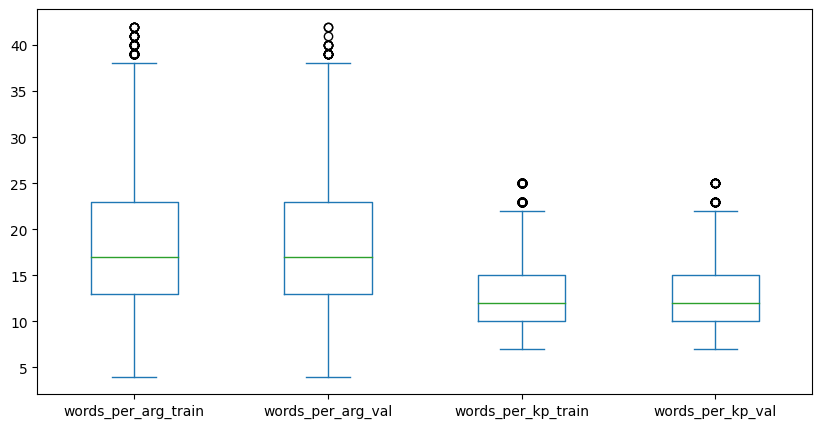

In [60]:
n_words.plot.box(figsize=(10, 5))

In [68]:
# Load our model's (bert-base-uncased) tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize data
tokenized = data_handler.tokenize_df(df_train[:100], tokenizer)

In [74]:
print(f'Vocabulary size of tokenizer:', tokenizer.vocab_size, '\nContext size:', tokenizer.model_max_length)

Vocabulary size of tokenizer: 30522 
Context size: 512


In [161]:
model = SiameseNetwork(bert_type=BertModel.from_pretrained('bert-base-uncased'))

train_loader = DataLoader(tokenized, shuffle=False, batch_size=32)

#train_loss = ContrastiveLoss()
train_loss = losses.ContrastiveLoss()

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

# The BERT authors recommend between 2 and 4.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for epoch in range(1, epochs + 1):
    train(model, None, train_loader, ContrastiveLoss, optimizer, epoch, scheduler)
    #test(model, device, test_loader)


In [179]:
def compute_contrastive_loss(left_feature, right_feature, label, margin):

    """
    Compute the contrastive loss as in


    L = 0.5 * Y * D^2 + 0.5 * (Y-1) * {max(0, margin - D)}^2

    **Parameters**
     left_feature: First element of the pair
     right_feature: Second element of the pair
     label: Label of the pair (0 or 1)
     margin: Contrastive margin

    **Returns**
     Return the loss operation

    """

    label = label.float()
    one = 1.0

    d = compute_euclidean_distance(left_feature, right_feature)
    d_sqrt = torch.sqrt(compute_euclidean_distance(left_feature, right_feature))
    first_part = torch.matmul(one-label, d)# (Y-1)*(d)

    max_margin = torch.maximum(margin-d_sqrt, torch.tensor(0))
    
    max_part = torch.square(max_margin)
    second_part = torch.matmul(label, max_part)  # (Y) * max(margin - d, 0)

    loss = 0.5 * torch.mean(first_part + second_part)

    return loss

def compute_euclidean_distance(x, y):
    """
    Computes the euclidean distance between two tensorflow variables
    """

    d = torch.sum(torch.square(torch.sub(x, y)),1)
    return d

In [12]:
def compute_contrastive_loss(left_feature, right_feature, label, margin):

    """
    Compute the contrastive loss as in


    L = 0.5 * Y * D^2 + 0.5 * (Y-1) * {max(0, margin - D)}^2

    **Parameters**
     left_feature: First element of the pair
     right_feature: Second element of the pair
     label: Label of the pair (0 or 1)
     margin: Contrastive margin

    **Returns**
     Return the loss operation

    """
    
    # -y * log(sim) + (1-y)*log(1-sim)

    label = label.float()
    
    cosine = torch.nn.CosineSimilarity()
    
    sim = torch.mean(torch.square(cosine(left_feature, right_feature))).resize(1)
    one = 1.0
   
    loss = torch.matmul(-label, torch.log(sim)) + torch.matmul((one-label).double(), torch.log(one-sim).double())
    
    return loss

In [140]:
def ContrastiveLoss(output1, output2, labels):
    
    loss = torch.tensor(0.0)
    
    for i in range(output1.size(0)):
    
        loss += compute_contrastive_loss(output1[i], output2[i], labels[i].resize(1), 0.1)
        print(loss)
    
    return loss

In [275]:
ContrastiveLoss(output1, output2, labels)

tensor(-16.8239, grad_fn=<AddBackward0>)

In [18]:
df_train[df_train['labels'] == 1].index

Int64Index([13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108,
            13109,
            ...
            16498, 16499, 16500, 16501, 16502, 16503, 16504, 16505, 16506,
            16507],
           dtype='int64', length=3408)